# Eurovision Turing Data Story

> Exploring (non-musical) factors contributing to Eurovision votes in the past 25 years.

- toc: false
- categories: [list, of, tags] (see previously used tags [here](https://alan-turing-institute.github.io/TuringDataStories-fastpages/categories/))
- author(s): list authors
- image: images/story_previews/<file here>

Authors
 - Ed Chapman
 - Katriona Goldmann
 - Radka Jersakova
 - David Llewellyn-Jones
 - Joe Palmer
 - Camila Rangel Smith
 - Martin Stoffel
 - Jonathan Yong
 
 **Reviewers:**
- Reviewer 1
- Reviewer 2

# Introduction

The Eurovision Song Contest, or *Eurovision* for short, is an annual competition featuring (mostly) European countries. It is in fact the longest running international televised music competitions, having started in 1951 as what was then seen as a technical experiment in transnational live broadcasting. The competition has continued every year since &mdash; except in 2020 when it was cancelled, [much to Iceland's chagrin](https://youtu.be/1HU7ocv3S2o), due to the pandemic &dash; and has grown in terms of number of countries participating, musical variety, visual flair and (some might say) fantastical preposterousness.

Despite the name, the Eurovision Song Content is neither about Europe, nor Singing. According to the Eurovision website, the European Broadcasting Union which runs the contest is made up of "56 countries and an additional 31 Associates in Asia, Africa, Australasia and the Americas". The contest itself is billed as a *songwriting* competition.

There are [strict requirements](https://eurovision.tv/about/rules) that songs and performers must comply with. Songs must be original; under three minutes long; sung live without lip syncing and with no live plugging instruments.

Typically the winning country is expected to host the technically challenging and costly event the following year (a 'prize' that [allegedly led to](https://www.irelandbeforeyoudie.com/why-ireland-stopped-winning-eurovision/) Ireland entering sub-par acts for at least a decade in a deliberate attempt to avoid winning). As many readers will no-doubt be aware, in 2022 the competition was won by Kalush Orchestra from Ukraine, with their song [Stefania](https://youtu.be/F1fl60ypdLs). This would ordinarily mean the 2023 event would be held in Ukraine, however this was deemed unsafe in light of the Russian invasion. The UK (the 2022 runners-up) therefore stepped in, meaning that this year's contest will be held in Liverpool, on 9–13 May 2023.

The seventy-year history of the event means there is now a large body of data about it to work with, as well as a large number of great songs to listen to. As you work through this Turing Data Story, we strongly recommend you listen to some of the great Eurovision masterpieces as your backing track, from the likes of [Celine Dion](https://youtu.be/w6b7BHGkKQA), [Bucks Fizz](https://youtu.be/h4-lKMGII_k), [Lordi](https://youtu.be/gAh9NRGNhUU), [Loreen](https://youtu.be/Pfo-8z86x80) and of course [Abba](https://youtu.be/Vp1_OKawHYw).

<center>
    <img alt="meme comparing what I think I look like discussing eurovision: two men casually talking to sofa; to what I actually look like: Charlie Kelly looking wild-eyed in front of a peg board full of conspiracy connections" src="eurovision_meme.jpeg" />
</center>

In the current format, participating countries first take part in a semifinal; the top 10 from each semifinal qualify for the finals.
The host country, as well as the "Big Five" (France, Germany, Italy, Spain, and the UK, which make greater financial contributions), directly qualify for the finals.

Our aim with this Story has been to try to uncover some of the hidden mysteries of Eurovision voting, and also to make some predictions &mdash; based purely on this data &mdash; for which countries are likely to fare well, and which less well, at this year's contest. We have pooled data from a number of different sources with the aim of understanding trends in the contest voting patterns. Our ultimate goal is to use this dataset to predict the winners of the [2023 event in Liverpool](https://eurovision.tv/event/liverpool-2023).

We have pooled data from a number of different sources with the aim of understanding trends in the contest voting patterns. We have also tried to make the data as accessible as possible. The curated data frame is available in the `data/df_main.csv` file, and the code to create this dataset is in `data.ipynb`.

Our goal is to use this dataset to predict the winners of the [2023 event in Liverpool](https://eurovision.tv/event/liverpool-2023).

We will start by exploring the data we have curated in terms of:
- voting scores
    - the best performing countries historically
    - countries who's votes deviate from the norm (biases in voting patterns)
    - countries who under- or over-score one another, and countries where the scoring is one sided.
- migration data
    - information about migration flows between voting-performing pairs and how this affects voting
- Performance language
- Artist gender

We will then build a model to predict the winner of the 2023 contest in a subsequent notebook.

## Setup

We begin by importing packages and setting up any configuration needed.

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path

import seaborn as sns
sns.set_theme(style="whitegrid")

if not Path("../../plots/").exists():
    Path("../../plots/").mkdir()

# Data

We can now continue by exploring the data we have curated in terms of: 
- voting scores
    - the best performing countries historically
    - countries who's votes deviate from the norm (biases in voting patterns)
    - countries who under- or over-score one another, and countries where the scoring is one sided. 
- migration data
    - information about migration flows between voting-performing pairs and how this affects voting
- Performance language
- Artist gender

We will then build a model to predict the winner of the 2023 contest in a subsequent notebook.

Data were obtained from the following sources:
 - **TODO** Voting scores
 - **TODO** Performer and song info (incl language)
 - **TODO** Population
 - **TODO** Migration statistics
 - **TODO** Border data
 - **TODO** Winners of each year
 
and aggregated into a CSV file, which can be downloaded from **TODO link**.
To avoid focusing unnecessarily on the data collection process, we simply import this data here.
(**TODO?** For those interested, a data cleaning notebook is hosted separately at LINK.)

The data only includes entries which reached the final; thus, not every participating country is represented every year.

In [80]:
df = pd.read_csv('../../data/df_main.csv')

df.head()

,year,Artist,from_country,to_country,points,total_points,rank,from_code2,from_code3,to_code2,...,gender,migration_v2p,population_p,prop_emigrants_v2p,migration_p2v,population_v,prop_emigrants_p2v,migration_pop_year,comps_without_win,has_border
0,1998,Danijela,belgium,croatia,5,131,5.0,BE,BEL,HR,...,female,205.0,4620030.0,0.000044,72.0,10136811.0,0.000007,1995.0,42,False
1,1998,Michael Hajiyanni,belgium,cyprus,2,37,11.0,BE,BEL,CY,...,male,92.0,862418.0,0.000107,77.0,10136811.0,0.000008,1995.0,42,False
2,1998,Koit Toome,belgium,estonia,0,36,12.0,BE,BEL,EE,...,male,0.0,1436634.0,0.000000,57.0,10136811.0,0.000006,1995.0,42,False
3,1998,Vlado Janevski,belgium,north macedonia,0,16,19.0,BE,BEL,MK,...,male,NaN,NaN,NaN,120.0,10136811.0,0.000012,1995.0,42,False
4,1998,Edea,belgium,finland,0,22,15.0,BE,BEL,FI,...,group,144.0,5107790.0,0.000028,1541.0,10136811.0,0.000152,1995.0,42,False


# Covariate visualisation

We begin by performing some exploratory visualisations of the data available to us.
The aim here is to discover some interesting trends, or specific data points, which reveal some underlying information about how Eurovision voting works.

## The Best Performing Countries

Lets determine the winners each year

In [81]:
winners = df.loc[df['rank'] == 1, ['to_country', 'total_points', 'rank', 'to_code2', 'year']]
winners = winners.drop_duplicates()

winners

,to_country,total_points,rank,to_code2,year
10,israel,172,1.0,IL,1998
618,sweden,163,1.0,SE,1999
1109,denmark,195,1.0,DK,2000
1660,estonia,198,1.0,EE,2001
2176,latvia,176,1.0,LV,2002
2737,turkey,167,1.0,TR,2003
3362,ukraine,280,1.0,UA,2004
4188,greece,230,1.0,GR,2005
5098,finland,292,1.0,FI,2006
5998,serbia,268,1.0,RS,2007


The countries who have won multiple times in this time frame are:

In [82]:
winners['to_country'].value_counts().loc[winners['to_country'].value_counts() > 1]

ukraine    3
sweden     3
israel     2
denmark    2
Name: to_country, dtype: int64

These are the countries with the best average score (though we only count countries who have participated at least 5 times in the finals).

In [83]:
temp = df[['to_country', 'to_code2', 'total_points', 'year']].drop_duplicates()

(temp.groupby('to_country')['total_points']
 .agg(['count', 'mean'])
 .query('count >= 5')
 .sort_values(by='mean', ascending=False)
 .head())

,count,mean
to_country,,
italy,11,170.545455
bulgaria,5,166.400000
ukraine,17,156.647059
russian federation,19,153.473684
sweden,23,142.043478


In [84]:
my_cmap = plt.get_cmap("magma_r")
rescale = lambda y: y / 26


def plot_country(code, ax, df_plot):
    df_temp = df_plot.loc[df_plot['to_code2'] == code]

    df_temp = df_temp.sort_values('year', ascending=False)    

    country_name = df_temp['to_country'].iloc[0].title()

    # for year in 1997 - 2022 not in df_temp['year'] add a row
    for i in range(1997, 2022):
        if (i not in df_temp['year'].values):
            df_add = pd.DataFrame(dict(year= i, total_points= np.nan, 
                        rank= np.nan, to_code2= code, to_country= country_name), 
                        index=[0])
            df_temp = pd.concat([df_temp, df_add], ignore_index=True)

    ax.bar(df_temp['year'], df_temp['total_points'], 
            color=my_cmap(rescale(df_temp['rank'])))

    ax.scatter(2020, 10, s=25, color='grey', marker="_")

    # annotate if nan (did not perform)
    for i, v in enumerate(df_temp.loc[df_temp['year'] != 2020, 'total_points']):
        if np.isnan(v):
            ax.scatter(df_temp['year'].iloc[i], 10, s=25, color='grey', marker="x")


    winner = df_temp.loc[df_temp['rank'] == 1, ['year', 'total_points']]
    winner = winner.drop_duplicates()
    if winner.shape[0] > 0:
        ax.scatter(winner['year'], winner['total_points'], s=50, 
                    color='gold', marker="*", edgecolor='black', zorder=5)

    ax.set_xlim(1997, 2023)
    ax.set_title(country_name)


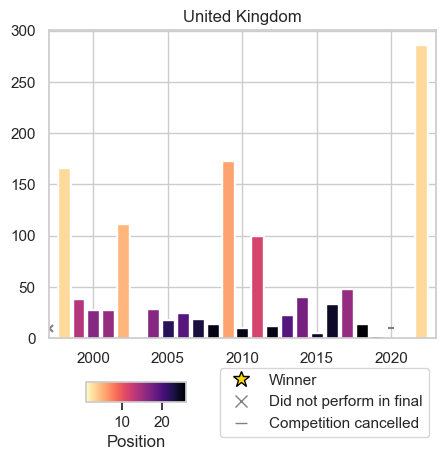

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), sharey=True, sharex=True, squeeze=True)

plot_country('GB', ax, df)

legend_elements = [Line2D([0], [0], marker='*', color='white', label='Winner',
                          markerfacecolor='gold', markersize=12, markeredgecolor='black'),                          
                  Line2D([0], [0], marker='x', color='white', label='Did not perform in final',
                          markerfacecolor='grey', markersize=8, markeredgecolor='grey'), 
                  Line2D([0], [0], marker='_', color='white', label='Competition cancelled',
                          markerfacecolor='grey', markersize=8, markeredgecolor='grey')]
fig.legend(handles=legend_elements, loc='right', ncol=1, bbox_to_anchor=(0.9, -0.05))

sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=1, vmax=26))
cbaxes = fig.add_axes([0.2, -0.05, 0.2, 0.05]) # x y deltax deltay

fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1, label='Position', 
             cax = cbaxes)

# save to file
plt.savefig('../../plots/uk_scores.pdf', bbox_inches='tight')


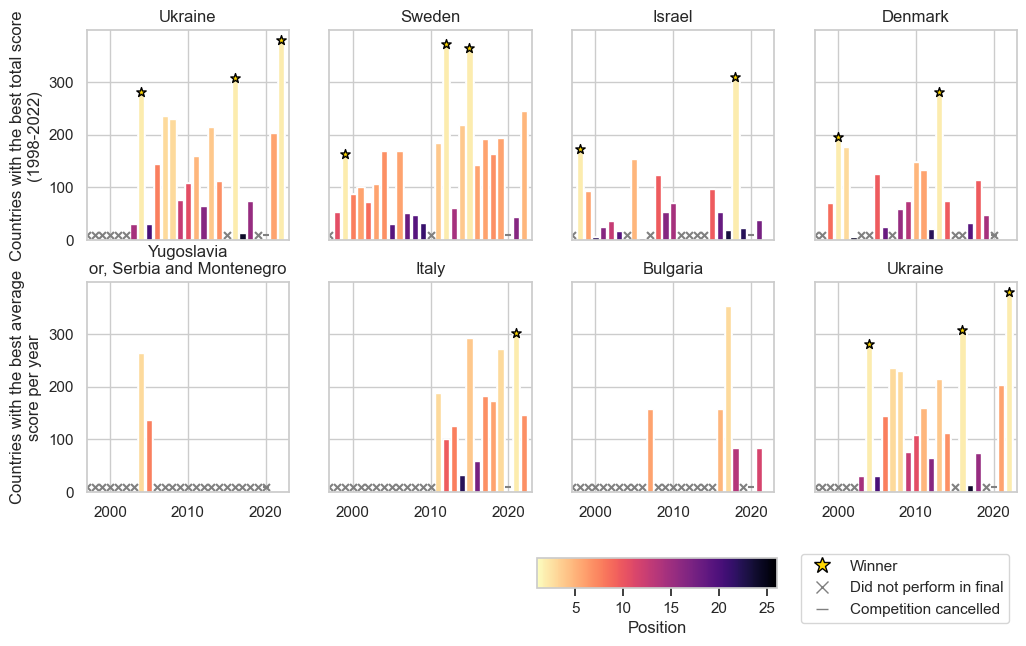

In [86]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True, squeeze=True)

plot_countries = winners['to_code2'].value_counts().loc[winners['to_code2'].value_counts() > 1].index

# add text for second row title
ax[0, 0].text(-0.3, 0.5, 'Countries with the best total score\n(1998-2022)', 
                  horizontalalignment='center', verticalalignment='center', 
                  transform=ax[0, 0].transAxes, fontsize=12, rotation=90)
ax[1, 0].text(-0.3, 0.5, 'Countries with the best average\nscore per year', 
                  horizontalalignment='center', verticalalignment='center', 
                  transform=ax[1, 0].transAxes, fontsize=12, rotation=90)

for i in range(len(plot_countries)): 
    plot_country(plot_countries[i], ax[0, i], df)

plot_countries = temp.groupby('to_code2')['total_points'].mean().sort_values(ascending=False).index[:4]
for i in range(len(plot_countries)): 
    plot_country(plot_countries[i], ax[1, i], df)

fig.legend(handles=legend_elements, loc='right', ncol=1, bbox_to_anchor=(0.9, -0.05))

sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=1, vmax=26))
cbaxes = fig.add_axes([0.5, -0.05, 0.2, 0.05]) # x y deltax deltay

fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1, label='Position', 
             cax = cbaxes)

ax[1][0].set_title("Yugoslavia\nor, Serbia and Montenegro")

plt.savefig('../../plots/top_performers_scores.pdf', bbox_inches='tight')


## Voting Country Deviations from Average Performance Scores

Calculate the voting deviations from the mean each country receives. 

In [87]:
df_voting= df[['from_country', 'points', 'to_country', 'year']].copy()

# The average votes for each To country
df_voting['avg_votes_per_pcountry'] = df_voting.groupby(['to_country'])['points'].transform('mean')

# The average votes for each To country
df_voting['avg_votes_per_pcountry_per country'] = df_voting.groupby(['to_country', 'from_country'])['points'].transform('mean')

# For each voting instance calculate the deviation from the average votes
df_voting['avg_difference_votes'] = df_voting['avg_votes_per_pcountry_per country'] - df_voting['avg_votes_per_pcountry']    

# If no_instances < 3, set avg_difference_votes to NaN, since this is not a reflective sample
df_voting['no_instances'] = df_voting.groupby(['from_country', 'to_country'])['avg_difference_votes'].transform('count')
df_voting.loc[df_voting['no_instances'] < 3, 'avg_difference_votes'] = np.nan

df_voting.head()

,from_country,points,to_country,year,avg_votes_per_pcountry,avg_votes_per_pcountry_per country,avg_difference_votes,no_instances
0,belgium,5,croatia,1998,2.050725,0.833333,-1.217391,12
1,belgium,2,cyprus,1998,1.766667,1.200000,-0.566667,15
2,belgium,0,estonia,1998,2.624729,1.076923,-1.547806,13
3,belgium,0,north macedonia,1998,1.764901,0.000000,-1.764901,9
4,belgium,0,finland,1998,1.706009,1.461538,-0.244470,13


Average countries received 

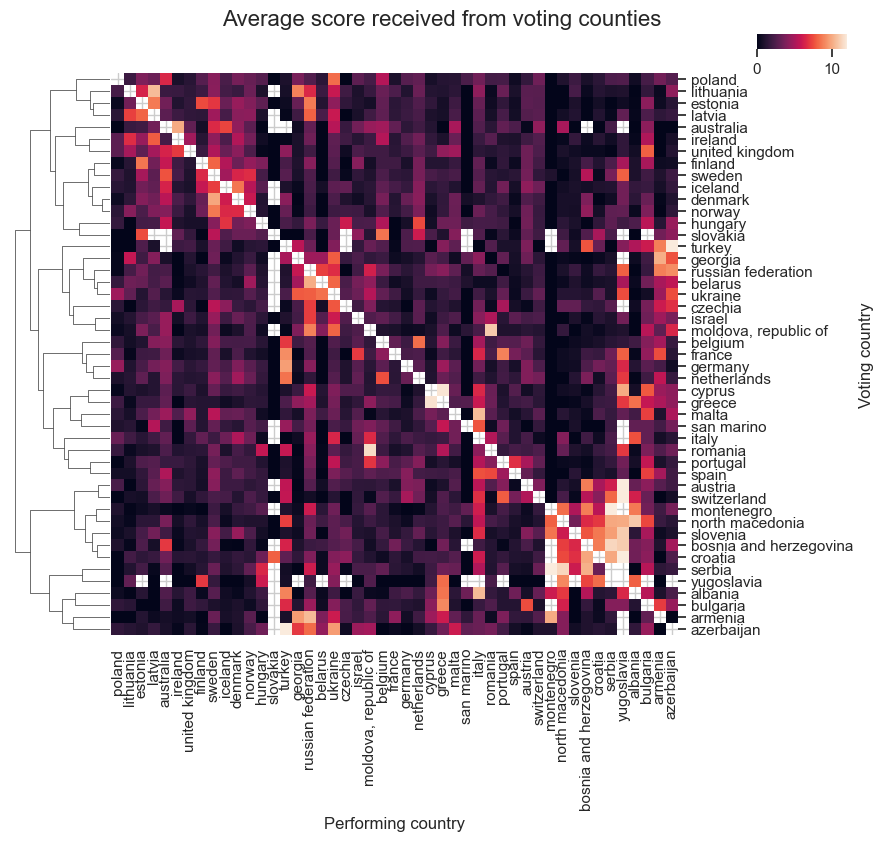

In [88]:
df_voting_heatmap = df_voting[['from_country', 'avg_votes_per_pcountry_per country', 'to_country']]
df_voting_heatmap = df_voting_heatmap.drop_duplicates()

# if from country = to country, set avg_difference_votes to NaN
df_voting_heatmap.loc[df_voting_heatmap['from_country'] == df_voting_heatmap['to_country'], 'avg_votes_per_pcountry_per country'] = np.nan

df_voting_heatmap = df_voting_heatmap.dropna(subset=['avg_votes_per_pcountry_per country'])

df_heatmap = df_voting_heatmap.pivot(index='from_country', columns='to_country', values='avg_votes_per_pcountry_per country')

df_heatmap.head()

import scipy.spatial as sp, scipy.cluster.hierarchy as hc

df_heatmap2 = df_heatmap.copy()

# row order to match column order
df_heatmap2 = df_heatmap2.reindex(df_heatmap2.columns)

row_dism = 1 - df_heatmap2.T.corr()
row_linkage = hc.linkage(sp.distance.squareform(row_dism), method='complete')

plot = sns.clustermap(df_heatmap2, row_linkage=row_linkage, col_linkage=row_linkage, 
                figsize=(9,8), mask=df_heatmap2.isnull(), 
                dendrogram_ratio= [0.15, 0.01],
                cbar_pos = (0.85,1,0.1,.019), # x,y, delta x, delta y
                cbar_kws={"orientation": "horizontal"},
                #cmap='viridis', 
                #center=0, 
                xticklabels=1, yticklabels=1)

plot.ax_col_dendrogram.set_visible(False) 

from matplotlib.patches import Rectangle
ax = plot.ax_heatmap


plot.fig.suptitle('Average score received from voting counties', fontsize=16, y=1.05)
plot.ax_heatmap.set_ylabel('Voting country')
plot.ax_heatmap.set_xlabel('Performing country')

#plt.show()

plt.savefig('../../plots/deviation_from_average_received_scores.pdf', bbox_inches='tight')

Average deviations

In [89]:
df_voting_heatmap = df_voting[['from_country', 'avg_difference_votes', 'to_country']]
df_voting_heatmap = df_voting_heatmap.drop_duplicates()

# if from country = to country, set avg_difference_votes to NaN
df_voting_heatmap.loc[df_voting_heatmap['from_country'] == df_voting_heatmap['to_country'], 'avg_difference_votes'] = np.nan

df_voting_heatmap = df_voting_heatmap.dropna(subset=['avg_difference_votes'])

df_heatmap = df_voting_heatmap.pivot(index='from_country', columns='to_country', values='avg_difference_votes')

df_heatmap.head()

to_country,albania,armenia,australia,austria,azerbaijan,belarus,belgium,bosnia and herzegovina,bulgaria,croatia,...,russian federation,san marino,serbia,slovenia,spain,sweden,switzerland,turkey,ukraine,united kingdom
from_country,,,,,,,,,,,,,,,,,,,,,
albania,NaN,-1.716775,-0.929752,-1.768099,-0.630292,-0.970085,-2.430751,2.812081,1.301478,-0.907867,...,-1.621569,2.719298,-1.439975,-1.269663,1.957285,-1.327451,0.975210,5.600664,-2.128149,0.447851
andorra,-1.738579,-2.625866,NaN,NaN,NaN,NaN,NaN,-2.521253,NaN,-2.050725,...,-1.954902,NaN,NaN,NaN,8.568396,-1.200000,NaN,-2.774336,1.434351,-0.441038
armenia,-1.738579,NaN,-2.763085,-0.982385,-2.847075,2.529915,-1.347418,-1.521253,-1.098522,-1.650725,...,6.166310,NaN,-1.248056,-1.269663,0.139825,-0.802564,0.432353,-2.474336,1.934351,-0.798181
australia,-1.738579,-2.625866,NaN,-2.232385,-2.937984,NaN,2.119249,NaN,0.151478,NaN,...,-1.288235,NaN,-0.636945,-1.269663,0.996968,2.538095,2.165686,NaN,1.334351,1.558962
austria,1.404278,0.088420,0.570248,NaN,-0.937984,-0.703419,-0.953478,6.228747,0.101478,2.949275,...,-1.645378,-0.614035,3.307499,-0.602996,-1.098270,0.022222,1.707353,2.350664,-1.527187,-0.107704


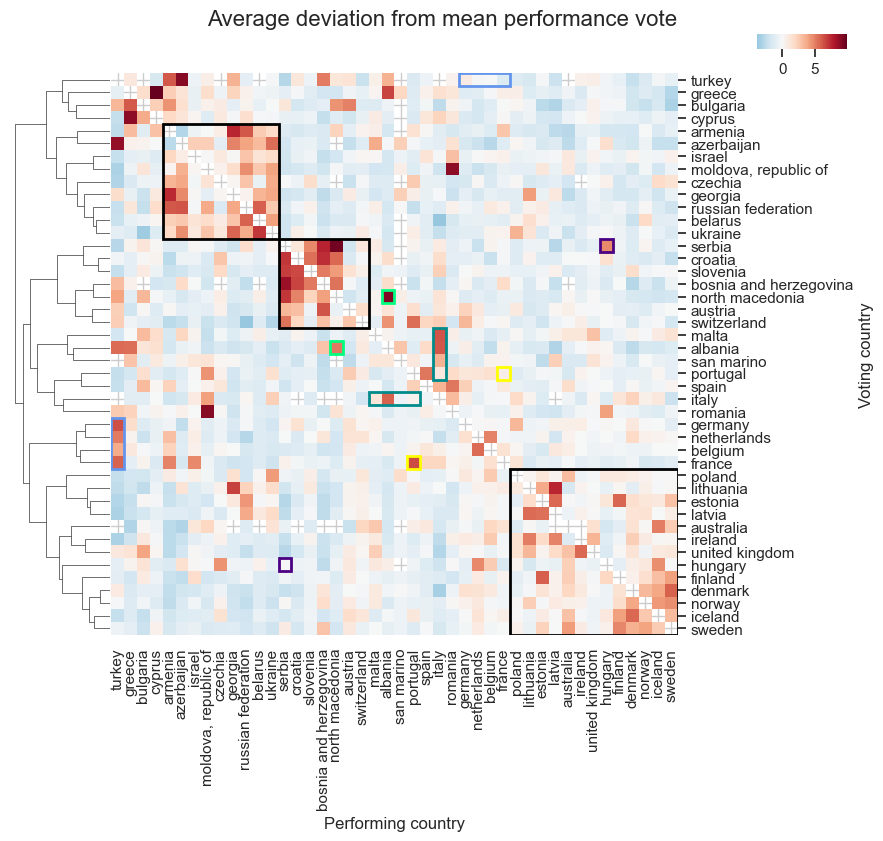

In [90]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

df_heatmap2 = df_heatmap.copy()

# row order to match column order
df_heatmap2 = df_heatmap2.reindex(df_heatmap2.columns)

row_dism = 1 - df_heatmap2.T.corr()
row_linkage = hc.linkage(sp.distance.squareform(row_dism), method='complete')

plot = sns.clustermap(df_heatmap2, row_linkage=row_linkage, col_linkage=row_linkage, 
                figsize=(9,8), mask=df_heatmap2.isnull(), 
                dendrogram_ratio= [0.15, 0.01],
                cbar_pos = (0.85,1,0.1,.019), # x,y, delta x, delta y
                cbar_kws={"orientation": "horizontal"},
                cmap='RdBu_r', center=0, xticklabels=1, yticklabels=1)

plot.ax_col_dendrogram.set_visible(False) 

from matplotlib.patches import Rectangle
ax = plot.ax_heatmap

ax.add_patch(Rectangle((4, 4), 9, 9, fill=False, edgecolor='black', lw=2))
ax.add_patch(Rectangle((df_heatmap2.shape[1]-13, df_heatmap2.shape[1]-13), 13, 13, fill=False, edgecolor='black', lw=2))
ax.add_patch(Rectangle((13, 13), 7, 7, fill=False, edgecolor='black', lw=2))

ax.add_patch(Rectangle((0, 27), 1, 4, fill=False, edgecolor='cornflowerblue', lw=2)) # turkey-germany, netherlands, belgium, france
ax.add_patch(Rectangle((27, 0), 4, 1, fill=False, edgecolor='cornflowerblue', lw=2))

ax.add_patch(Rectangle((20, 25), 4, 1, fill=False, edgecolor='darkcyan', lw=2)) # italy-malta, san marino, albania, portugal
ax.add_patch(Rectangle((25, 20), 1, 4, fill=False, edgecolor='darkcyan', lw=2))

ax.add_patch(Rectangle((13, 38), 1, 1, fill=False, edgecolor='indigo', lw=2)) # serbia-hungary
ax.add_patch(Rectangle((38, 13), 1, 1, fill=False, edgecolor='indigo', lw=2))

ax.add_patch(Rectangle((21, 17), 1, 1, fill=False, edgecolor='springgreen', lw=2)) # north-macedonia-albania
ax.add_patch(Rectangle((17, 21), 1, 1, fill=False, edgecolor='springgreen', lw=2))

ax.add_patch(Rectangle((30, 23), 1, 1, fill=False, edgecolor='yellow', lw=2)) # portugal-france
ax.add_patch(Rectangle((23, 30), 1, 1, fill=False, edgecolor='yellow', lw=2))

plot.fig.suptitle('Average deviation from mean performance vote', fontsize=16, y=1.05)
plot.ax_heatmap.set_ylabel('Voting country')
plot.ax_heatmap.set_xlabel('Performing country')

#plt.show()

plt.savefig('../../plots/deviation_from_average_received_scores.pdf', bbox_inches='tight')

In this plot, countries are grouped by ... **TODO** 

There are a number of interesting details in this plot.
For example, the black boxes indicate that Turkey's entries have consistently obtained higher-than-average scores from Germany, the Netherlands, Belgium, and France; but that this isn't reciprocated.
A possible hypothesis for this may be the fact there is a significant Turkish diaspora in these countries: according to Pashayan (2012), there were 10 million "Euro-Turks" in these four countries in 2012.

This suggests that migration data between two countries might be another useful thing to look at.

REF (to be done up properly, and actually just ref 5 from https://en.wikipedia.org/wiki/Turkish_diaspora): Pashayan, Araks (2012), "Integration of Muslims in Europe and the Gülen", in Weller, Paul; Ihsan, Yilmaz (eds.), European Muslims, Civility and Public Life: Perspectives On and From the Gülen Movement, Continuum International Publishing Group, ISBN 978-1-4411-0207-2.

## Voting Pair Plots

In [91]:
countries = df['from_country'].unique()

# Create a new dataframe containing the data for the scatter plot
votes = pd.DataFrame({'performer': [], 'voter': [], 'times_competed': [], 'times_voted': [], 'total_points': [], 'average_points': []})

# Compare every country with every other country
for performer in countries:
    times_competed = len(df.loc[df['to_country'] == performer]['year'].unique())
    for voter in countries:
        times_voted = len(df.loc[(df['to_country'] == performer) & (df['from_country'] == voter) & (df['points'] > 0)])
        total_points = df.loc[(df['to_country'] == performer) & (df['from_country'] == voter)]['points'].sum()
        average_points = df.loc[(df['to_country'] == performer) & (df['points'] >= 0) & (df['from_country'] == voter)]['points'].mean()
        votes.loc[len(votes)] = [performer, voter, times_competed, times_voted, total_points, average_points]
print('Check every country is matched with very other: {}'.format(len(countries)**2 == len(votes)))

Check every country is matched with very other: True


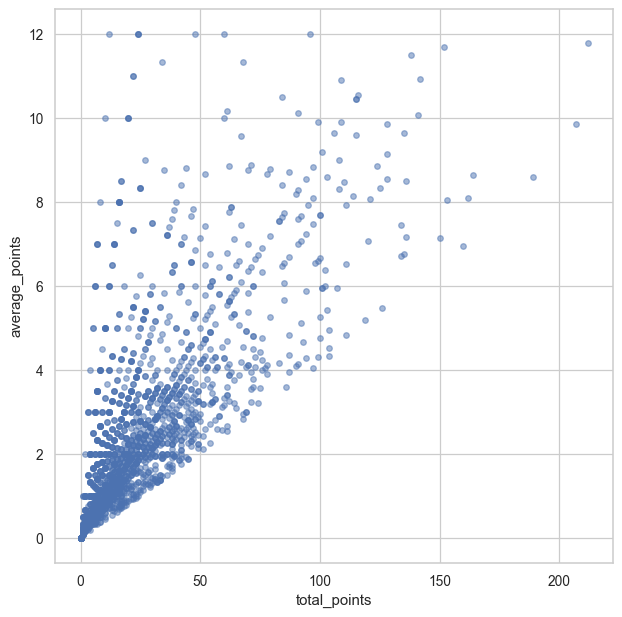

In [92]:
# Render a basic static scatter plot
fig = plt.figure(figsize=(8, 8), dpi=90)
votes.plot.scatter(x='total_points', y='average_points', alpha=0.5, ax = plt.gca())

plt.savefig('../../plots/total_vs_average_points.pdf', bbox_inches='tight')

In [93]:
import plotly.express as px

# Render an interactive (hoverable) plot
fig = px.scatter(votes, x='total_points', y='average_points')
fig.update_traces(hovertemplate='Performer: %{customdata[0]}'
                  + '<br>Voter: %{customdata[1]}'
                  + '<br>Total Eurovisions competed: %{customdata[2]}'
                  + '<br>Total times voted for by selected country: %{customdata[3]}'
                  + '<br>Total points given: %{customdata[4]}'
                  + '<br>Average points: %{customdata[5]:.2f}',
                  customdata=votes,
                  marker={'color': 'rgba(50, 50, 150, 0.1)', 'opacity': 0.5, 'size': 6,
                          'line': {'color': 'rgba(50, 50, 150, 1.0)', 'width': 1}})
fig.update_layout(hoverlabel_align='left', width=640, height=640, margin=dict(l=20, r=20, t=20, b=20),
                  xaxis={'title': 'Total voter points given to specific country'},
                  yaxis={'title': 'Average points'})
fig.show()

## Looking for Country Friendships, Biases, and One-sided relationships

After looking at broader patterns, let's now dive into some specific country-pairs. 
We will look for the top country pairs which
* give each other very high scores
* give each other very low scores
* have a one-sided relationship, where one country gives high scores to another, but gets low scores back 

In [94]:
# filter for where bothfrom_country and to_country is turkey or armenia
(df
  .query('from_country == "armenia" & to_country == "turkey"')
)

,year,Artist,from_country,to_country,points,total_points,rank,from_code2,from_code3,to_code2,...,gender,migration_v2p,population_p,prop_emigrants_v2p,migration_p2v,population_v,prop_emigrants_p2v,migration_pop_year,comps_without_win,has_border
5161,2006,Sibel Tüzün,armenia,turkey,0,91,11.0,AM,ARM,TR,...,female,765.0,68704715.0,0.000011,1503.0,3047246.0,0.000493,2005.0,2,True
6049,2007,Kenan Doğulu,armenia,turkey,0,163,4.0,AM,ARM,TR,...,male,765.0,68704715.0,0.000011,1503.0,3047246.0,0.000493,2005.0,3,True
7035,2008,Mor ve Ötesi,armenia,turkey,0,138,7.0,AM,ARM,TR,...,group,765.0,68704715.0,0.000011,1503.0,3047246.0,0.000493,2005.0,4,True
8085,2009,Hadise,armenia,turkey,4,177,4.0,AM,ARM,TR,...,female,765.0,68704715.0,0.000011,1503.0,3047246.0,0.000493,2005.0,5,True
9085,2010,maNga,armenia,turkey,0,170,2.0,AM,ARM,TR,...,group,789.0,73195345.0,0.000011,1250.0,2946293.0,0.000424,2010.0,6,True


In [95]:
# how often did each country participate?
n_participations = (df
                    .groupby('to_country')['year']
                    .nunique()
                    .sort_values(ascending=True))
# filter countries with less than 5 participations
countries_to_remove = n_participations[n_participations < 5].index.tolist()
# remove from df
df_pairs = df[~df['to_country'].isin(countries_to_remove)]
# get random 5 rows from df_pairs
df_pairs.sample(5)

,year,Artist,from_country,to_country,points,total_points,rank,from_code2,from_code3,to_code2,...,gender,migration_v2p,population_p,prop_emigrants_v2p,migration_p2v,population_v,prop_emigrants_p2v,migration_pop_year,comps_without_win,has_border
6717,2007,Sopho,romania,georgia,0,97,12.0,RO,ROU,GE,...,female,202.0,3902469.0,0.000052,0.0,21319685.0,0.000000,2005.0,51,False
8387,2009,Brinck,france,denmark,5,74,13.0,FR,FRA,DK,...,male,5206.0,5419432.0,0.000961,6496.0,63188395.0,0.000103,2005.0,8,False
9128,2010,Filipa Azevedo,belarus,portugal,0,43,18.0,BY,BLR,PT,...,female,834.0,10573100.0,0.000079,NaN,NaN,NaN,NaN,54,False
19232,2019,Katerine Duska,slovenia,greece,0,34,21.0,SI,SVN,GR,...,female,129.0,10820883.0,0.000012,91.0,2063531.0,0.000044,2015.0,13,False
7909,2008,Vânia Fernandes,switzerland,portugal,10,69,13.0,CH,CHE,PT,...,female,14775.0,10503330.0,0.001407,151305.0,7437115.0,0.020345,2005.0,52,False


In [96]:
# Grouping by performer and voter, calculate mean votes and count number of years
df_pairs = (df_pairs
    .groupby(['from_country', 'to_country'])
    .agg(votes = ('points', 'mean'), num_years = ('year', 'count'))
    .reset_index()
    .sort_values('votes', ascending=False)
)

# Merge original dataframe with its reverse
df_pairs = (df_pairs
    .merge(df_pairs.rename(columns={'from_country': 'to_country', 
                               'to_country': 'from_country'}), 
           on=['from_country', 'to_country'])
    .drop_duplicates()
    .query('from_country != to_country')
    .assign(votes_diff = lambda x: abs(x['votes_x'] - x['votes_y']))
    .reindex(columns=['from_country', 'to_country', 'num_years', 'votes_x', 'votes_y', 'votes_diff'])
)

# create combined column with pairs in alphabetical order
df_pairs['country_pair'] = df_pairs[['from_country', 'to_country']].apply(lambda x: ' - '.join(sorted(x)), axis=1)
# Remove duplicate country pairs and the temporary country_pair column
df_pairs = (df_pairs
            .drop_duplicates(subset=['country_pair'])
            .drop(columns=['country_pair']))

df_pairs.head()

,from_country,to_country,num_years,votes_x,votes_y,votes_diff
0,azerbaijan,turkey,NaN,12.000000,12.000000,0.000000
2,cyprus,greece,NaN,11.777778,11.692308,0.085470
4,romania,"moldova, republic of",NaN,11.500000,10.923077,0.576923
5,serbia,north macedonia,NaN,11.333333,9.909091,1.424242
6,bosnia and herzegovina,serbia,NaN,11.333333,10.166667,1.166667


In [97]:
# Number of country pairs to show for each category
N = 5

# top 5 country pairs with high votes for each other
top_highs = (df_pairs
    .query('votes_diff < 3')
    .sort_values('votes_x', ascending=False).head(N)
)

# top 5 country pairs with low votes for each other
top_lows = (df_pairs
    .query('votes_diff < 3')
    .sort_values('votes_x', ascending=True).head(N)
)

# top 5 unbalanced country pairs (one gives high votes to the other, but gets low votes back)
top_one_sided = (df_pairs
            .sort_values('votes_diff', ascending=False).head(N))

# combine 
top_relationships = (pd.concat([top_highs, top_lows, top_one_sided]))
# add grouping
top_relationships['group'] = ['high'] * N + ['low'] * N + ['one-sided'] * N

# sort by votes_x
top_relationships = top_relationships.sort_values('votes_x')

top_relationships['y'] = range(1, len(top_relationships) + 1)

top_relationships

,from_country,to_country,num_years,votes_x,votes_y,votes_diff,group,y
1662,italy,turkey,NaN,0.000000,0.000000,0.000000,low,1
1632,romania,georgia,NaN,0.000000,0.000000,0.000000,low,2
1620,albania,lithuania,NaN,0.090909,0.000000,0.090909,low,3
1621,armenia,azerbaijan,NaN,0.090909,0.000000,0.090909,low,4
1612,belarus,ireland,NaN,0.125000,0.000000,0.125000,low,5
32,turkey,armenia,NaN,8.800000,0.800000,8.000000,one-sided,6
26,france,turkey,NaN,9.142857,0.200000,8.942857,one-sided,7
21,germany,turkey,NaN,9.642857,2.466667,7.176190,one-sided,8
16,australia,ireland,NaN,10.000000,2.166667,7.833333,one-sided,9
9,malta,italy,NaN,10.545455,3.500000,7.045455,one-sided,10


In [98]:
# Replace group names with numeric values for sorting
group_order = {'low': 1, 'one-sided': 2, 'high': 3}
top_relationships['group_order'] = top_relationships['group'].replace(group_order)

# Create a new column representing the minimum value between 'votes_x' and 'votes_y'
top_relationships['min_votes'] = top_relationships[['votes_x', 'votes_y']].min(axis=1)

# Sort the DataFrame by 'group_order' and 'min_votes'
top_relationships = top_relationships.sort_values(by=['group_order', 'min_votes'], ascending=[True, True])

# Reassign the 'y' column after sorting
top_relationships['y'] = range(1, len(top_relationships) + 1)

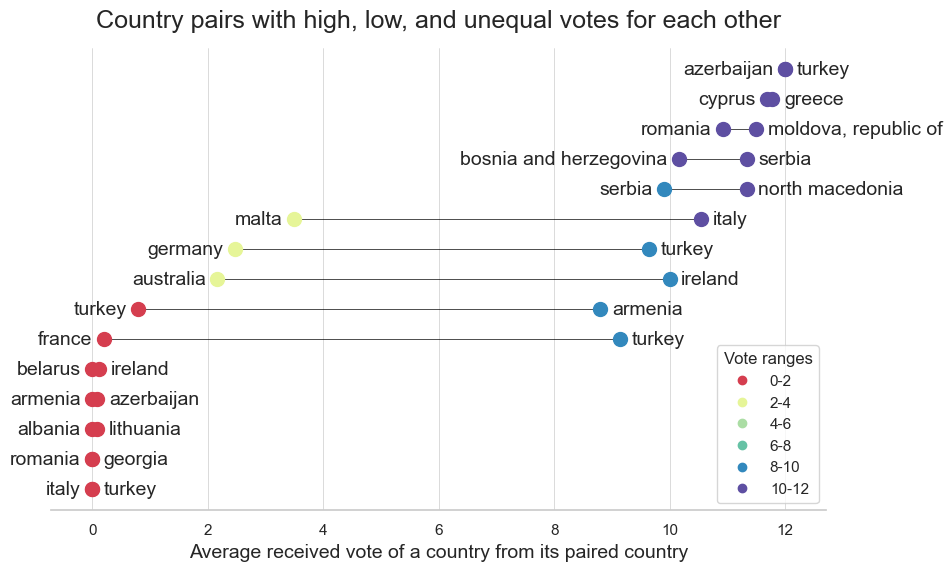

In [99]:
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(axis='x', linestyle='-', linewidth=0.5)

# create a color map with 6 colors from red to blue
colors = sns.color_palette("YlOrRd", 6)[::-1]
cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors, N=len(colors))

# get color map with viridis colors for 6 bins
cmap = plt.get_cmap('viridis' )

#colors = ["#b2182b", "#d1e5f0", "#92c5de", "#4393c3", "#2166ac", "#053061" ]
colors = ["#d53e4f", "#e6f598", "#abdda4", "#66c2a5", "#3288bd", "#5e4fa2"]
cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors, N=len(colors))


# define the range boundaries
bins = np.arange(0, 13, 2)

# add text labels and points
for i, row in top_relationships.iterrows():
    ax.text(row['votes_x']+0.2, row['y'] ,row['to_country'],  ha='left', va='center', fontsize=14)  # increase the value added to 'votes_x' for more space
    ax.text(row['votes_y']-0.2, row['y'] , row['from_country'],  ha='right', va='center', fontsize=14)  # increase the value subtracted from 'votes_y' for more space

    # plot points with colors based on x-value range
    x_color = np.digitize(row['votes_x'], bins=bins, right=True)-1
    y_color = np.digitize(row['votes_y'], bins=bins, right=True)-1
    ax.scatter(row['votes_x'], row['y'], color=cmap(x_color/6), s=100, alpha=1, zorder=3)
    ax.scatter(row['votes_y'], row['y'], color=cmap(y_color/6), s=100, alpha=1, zorder=3)

    # add line between countries with slightly shortened length
    line_buffer = 0.1
    ax.plot([row['votes_x'] + line_buffer, row['votes_y'] - line_buffer], [row['y'], row['y']], color='black', alpha=0.7, zorder=2, linewidth=0.7)

ax.set_xlabel('Average received vote of a country from its paired country', fontsize=14)
ax.set_ylabel('')

# Hide the y axis
ax.get_yaxis().set_visible(False)
ax.spines[['top', 'right', 'left']].set_visible(False)

# Add legend
markers = [plt.Line2D([0,0],[0,0], color=cmap(i/6), marker='o', linestyle='') for i in range(6)]
plt.legend(markers, ['{}-{}'.format(i, i+2) for i in bins[:-1]], numpoints=1, loc='lower right', title='Vote ranges')

plt.title('Country pairs with high, low, and unequal votes for each other', fontsize=18,  loc='center', pad=15)

fig.savefig('../../plots/country_relationships.pdf', bbox_inches='tight')

The plot shows the top 5 pairs of countries which give each other high, low and unequal scores.
The point next to a country name is the score it *received* from the other country. For example, both France and Germany on average get low scores from Turkey, but give Turkey high scores.
Cyprus and Greece give each other high scores, and Albania and Lithuania tend to give each other low scores.

The plot differs a bit from the results above, because it is looking at raw votes, not deviations from the mean vote.
Therefore, one-sided voting does not necessarily indicate bias in voting: it may simply be because the country has historically performed very well (or very poorly!) in Eurovision.

# Migration Data

 **TODO** Maybe plot prop_emigrants versus the score deviation?

One of our main goals was to predict the winner of the 2023 contest. On a finer scale, this means predicting how each country will vote for each other country. Arguably, countries with a large immigrant population from another country might give more favorable votes to that country. To test and incorporate this in our models, we used migration data from [Our World in Data](https://ourworldindata.org/migration). Specifically, we were interested in the proportion of immigrants in each country from each other country. We calculated both sides, i.e. proportion emigrants from the voter country in the perfomer country (v2p) and the other way round.

In [100]:
# migration data
df.filter(like='migr').head()

,migration_v2p,prop_emigrants_v2p,migration_p2v,prop_emigrants_p2v,migration_pop_year
0,205.0,0.000044,72.0,0.000007,1995.0
1,92.0,0.000107,77.0,0.000008,1995.0
2,0.0,0.000000,57.0,0.000006,1995.0
3,NaN,NaN,120.0,0.000012,1995.0
4,144.0,0.000028,1541.0,0.000152,1995.0


In [101]:
df_migration = df[['year', 'from_code2', 'to_code2', 'prop_emigrants_v2p', 'prop_emigrants_p2v', 'points']].copy()

# Calculate score deviation per year
df_migration['avg_votes'] = df_migration.groupby(['to_code2', 'year'])['points'].transform('mean')
df_migration['deviation'] = df_migration['points'] - df_migration['avg_votes']


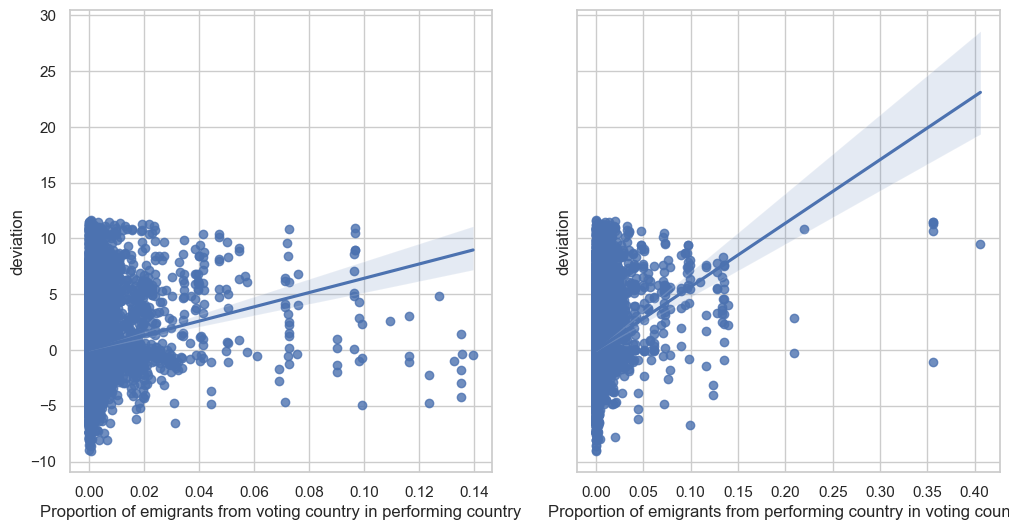

In [102]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 6))
sns.regplot(x='prop_emigrants_v2p', y='deviation', data=df_migration, ax=ax1)
sns.regplot(x='prop_emigrants_p2v', y='deviation', data=df_migration, ax=ax2)

ax1.set_xlabel('Proportion of emigrants from voting country in performing country')
ax2.set_xlabel('Proportion of emigrants from performing country in voting country')

#plt.show()

plt.savefig('../../plots/emigration.pdf', bbox_inches='tight')

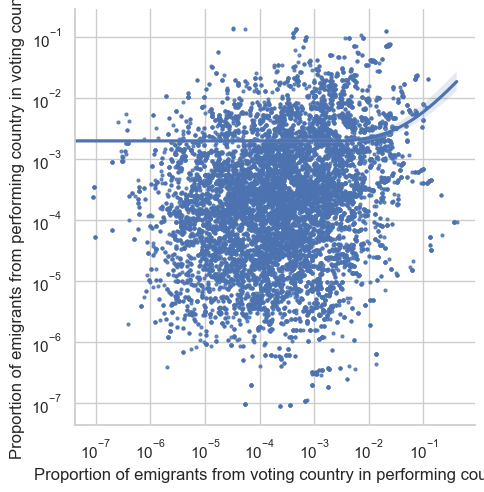

In [103]:
sns.lmplot(x='prop_emigrants_p2v', y='prop_emigrants_v2p', data=df_migration, scatter_kws={"s": 4})

# log scale axes
plt.xscale('log')
plt.yscale('log')

plt.xlabel("Proportion of emigrants from voting country in performing country")
plt.ylabel("Proportion of emigrants from performing country in voting country")
plt.show()

# Language Data

We are interested in three things:
1. Does the song contain english lyrics: yes vs no &#x2705;
2. What are the average votes for songs with english lyrics vs non-english lyrics &#x2705;
3. Does the performer sing in their official language yes vs no (english) vs no (non-english) &#x2705;
4. How many languages appear in the song vs votes? (can you hedge your bets?) &#x2705;
5. Are the votes received affected by whether or not a song is sung in the voting country's official language? &#x2705;

**TODO** Get language data cleaned up, see https://github.com/KatrionaGoldmann/Eurovision_TDS/blob/issue-5-exploratory_visualisations/eurovision/notebooks/language_visualistaions.ipynb.

**TODO** Discussion of Eurovision language rules (this has changed over time).

In this dataset, we have categorised the song language into one or more of: the country's official language (`own`), English (`eng`), or an entirely separate language (`other`).
When English *is* one of the country's official languages, both `own` and `other` are selected.
We can use this data to investigate how likely each country is to perform in English:

In [104]:
df_performance = df[['year', 'Artist', 'to_country', 
       'total_points', 
       'rank', 'to_code2',
       'Official_languages', 'Language_sung', 'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'Number_of_Languages', 'Contains_Own_Language', 'gender']].drop_duplicates()

In [105]:
df_performance.loc[df_performance['year'] == 2018]['to_country'].value_counts()

australia               1
austria                 1
united kingdom          1
ukraine                 1
sweden                  1
spain                   1
slovenia                1
serbia                  1
portugal                1
norway                  1
netherlands             1
moldova, republic of    1
lithuania               1
italy                   1
israel                  1
ireland                 1
hungary                 1
germany                 1
france                  1
finland                 1
estonia                 1
denmark                 1
czechia                 1
cyprus                  1
bulgaria                1
albania                 1
Name: to_country, dtype: int64

In [106]:
# get the percentage of performances who contain own language
print('Percentage of performances in own language:', round(sum(df_performance['Contains_Own_Language'])/len(df_performance) *100), '%')
print('Percentage of performances in English:', round(sum(df_performance['Contains_English'])/len(df_performance) *100), '%')

print('Percentage of performances by gender:')
df_performance['gender'].value_counts()/len(df_performance) * 100

Percentage of performances in own language: 46 %
Percentage of performances in English: 76 %
Percentage of performances by gender:


female    40.000000
male      30.333333
group     29.666667
Name: gender, dtype: float64

In [107]:
df_language = df_performance.copy()

df_performance['English_only'] = (df_performance['Contains_English']) & (df_performance['Number_of_Languages'] == 1 )
df_performance['No_English'] = ~df_performance['Contains_English'] 
df_performance['Some_English'] = (df_performance['Contains_English']) & (df_performance['Number_of_Languages'] > 1 )

# for each country get the ratio of songs that contain only English, some English and no English
# then sort by the ratio of songs that contain only English
df_language = df_performance.groupby('to_country').agg({'English_only': 'mean', 'Some_English': 'mean', 'No_English': 'mean'})

df_language = df_language.sort_values(by=['English_only', 'Some_English'], ascending=True)

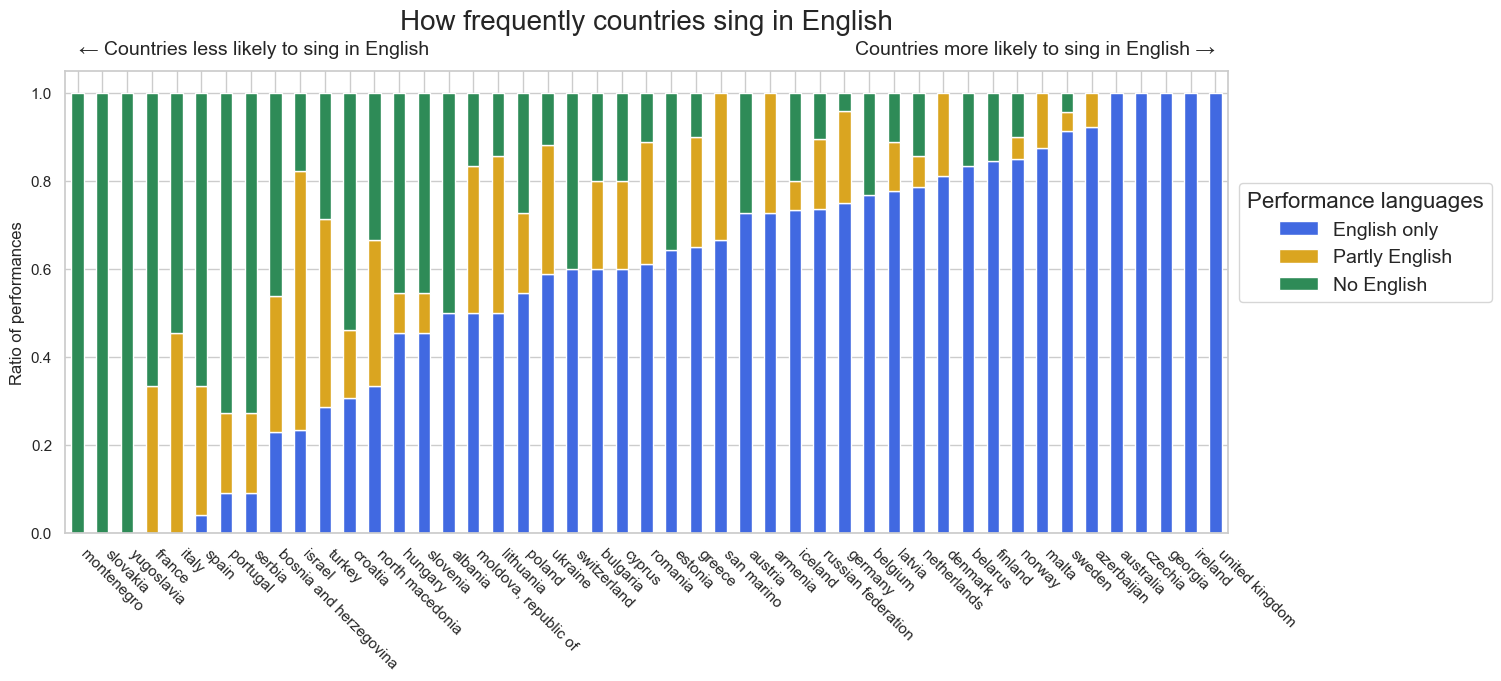

In [108]:
colours = {"English_only":'royalblue', "No_English":'seagreen', "Some_English":'goldenrod'}

df_language.plot(kind='bar', figsize=(15, 6), stacked=True, color=colours)

plt.legend(['English only', 'Partly English', 'No English'], title="Performance languages", loc=[1, 1], 
        fontsize=14,  bbox_to_anchor=(0.51, 0., 0.5, 0.5), title_fontsize=16)

plt.title('How frequently countries sing in English', fontsize=20, pad=30)

plt.text(df_language.shape[0]-1, 1.1, 'Countries more likely to sing in English →', ha='right', va='center', fontsize=14)
plt.text(0.05, 1.1, '← Countries less likely to sing in English ', ha='left', va='center',  fontsize=14)
plt.xticks(rotation=-45, ha='left')
plt.xlabel('')
plt.ylabel('Ratio of performances')

#plt.show()

plt.savefig('../../plots/english_performances.pdf', bbox_inches='tight')

In [109]:
# convert wide to long format
df_long = df_performance[['English_only', 'No_English',	'Some_English', 'total_points']]

df_long = df_long.melt(id_vars=['total_points'], var_name='language', value_name='contains_language')

df_long['contains_language'] = df_long['contains_language'].astype(int)

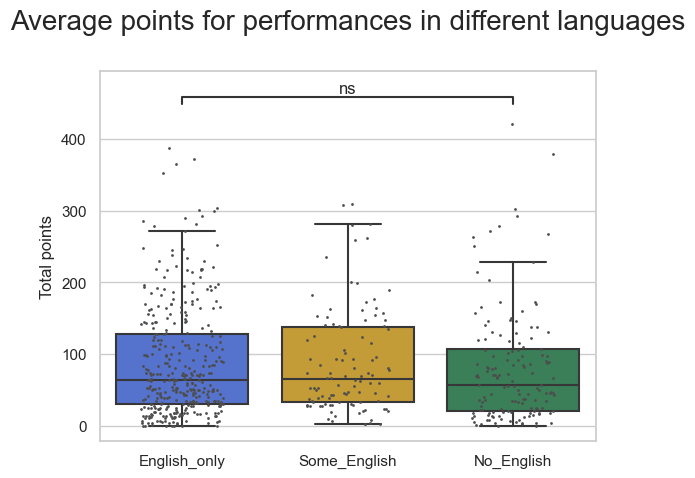

In [110]:
import scipy.stats as stats
from statannot import add_stat_annotation

# boxplots for each language type
ax = sns.boxplot(x='language', y='total_points', 
                 data=df_long.loc[df_long['contains_language'] > 0], 
                 palette=colours, showfliers=False, 
                 order=['English_only', 'Some_English', 'No_English'])
sns.stripplot(x='language', y='total_points', 
              order=['English_only', 'Some_English', 'No_English'],
              data=df_long.loc[df_long['contains_language'] > 0], 
              jitter=0.25, size=2, color=".3", linewidth=0)

plt.title('Average points for performances in different languages', fontsize=20, pad=30)
plt.xlabel('')
plt.ylabel('Total points')

add_stat_annotation(ax, data=df_long.loc[df_long['contains_language'] > 0],
                    x='language', y='total_points', 
                    order=['English_only', 'Some_English', 'No_English'],
                    box_pairs=[("English_only", "No_English")],
                    test='Mann-Whitney', text_format='star', verbose=0)

plt.show()

In [111]:
df_language = df_performance.copy()

df_performance['Own_language'] = (df_performance['Contains_Own_Language']) 
df_performance['Other_language'] = ~df_performance['Contains_Own_Language'] 

# for each country get the ratio of songs that contain only English, some English and no English
# then sort by the ratio of songs that contain only English
df_language = df_performance.groupby('to_country').agg({'Other_language': 'mean', 'Own_language': 'mean'})

df_language = df_language.sort_values(by=['Own_language', 'Other_language'], ascending=True)

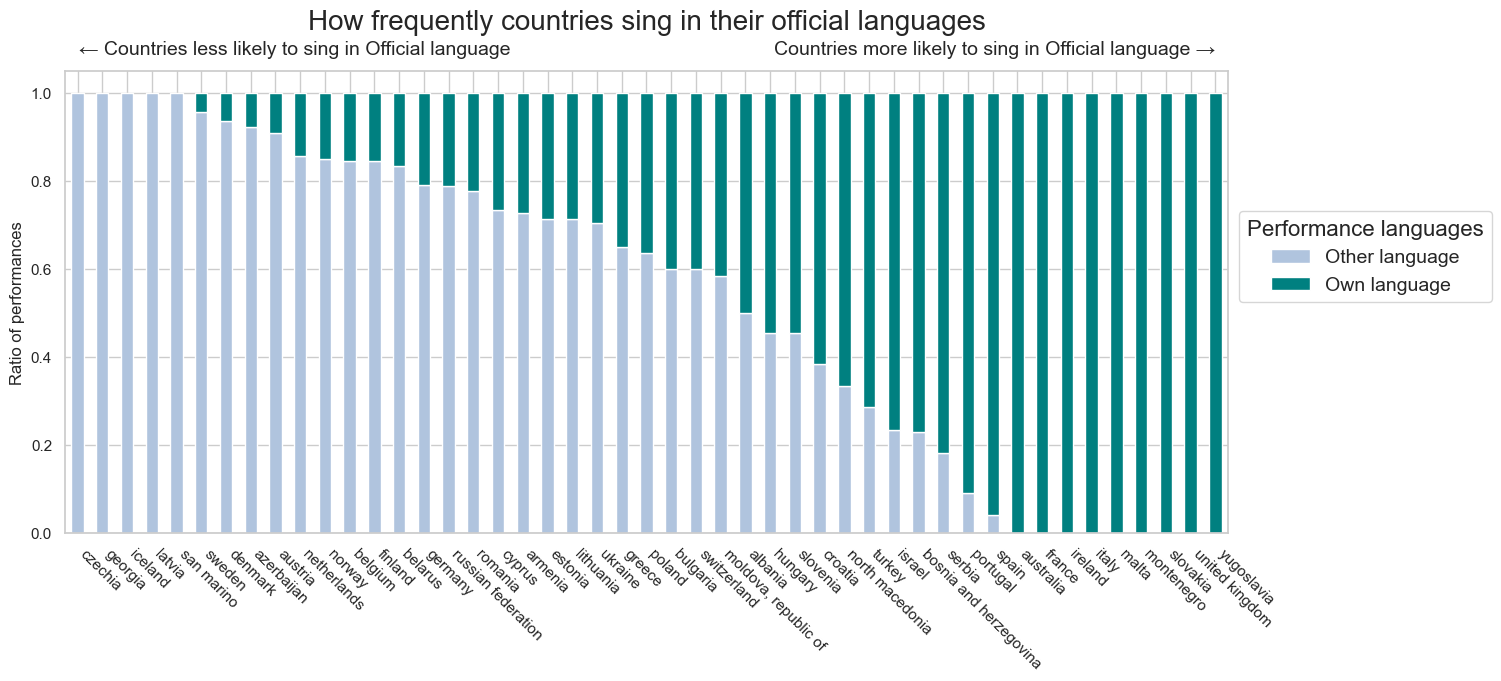

In [112]:
colours = {"Own_language":'teal', "Other_language":'lightsteelblue'}

df_language.plot(kind='bar', figsize=(15, 6), stacked=True, color=colours)

plt.legend(['Other language', 'Own language'], title="Performance languages", loc=[1, 1], 
        fontsize=14,  bbox_to_anchor=(0.51, 0., 0.5, 0.5), title_fontsize=16)

plt.title('How frequently countries sing in their official languages', fontsize=20, pad=30)

plt.text(df_language.shape[0]-1, 1.1, 'Countries more likely to sing in Official language →', ha='right', va='center', fontsize=14)
plt.text(0.05, 1.1, '← Countries less likely to sing in Official language ', ha='left', va='center',  fontsize=14)
plt.xticks(rotation=-45, ha='left')
plt.xlabel('')
plt.ylabel('Ratio of performances')

#plt.show()

plt.savefig('../../plots/official_languages.pdf', bbox_inches='tight')

Typically those on the left of this plot are countries who sing in english but english is not their official language. Those on the right are countries who sing in their official language exclusively.

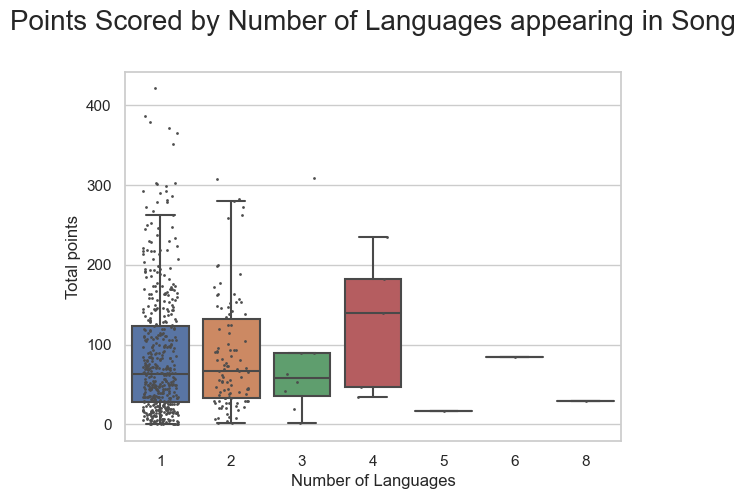

In [113]:
sns.boxplot(x='Number_of_Languages', y='total_points', data=df_performance, showfliers=False)
sns.stripplot(x='Number_of_Languages', y='total_points', data=df_performance, jitter=0.25, size=2, color=".3", linewidth=0)

plt.title('Points Scored by Number of Languages appearing in Song', fontsize=20, pad=30)
plt.xlabel('Number of Languages')
plt.ylabel('Total points')


plt.show()
#plt.savefig('../../plots/uk_scores.pdf', bbox_inches='tight')

<Axes: xlabel='Contains_Voting_Language', ylabel='points'>

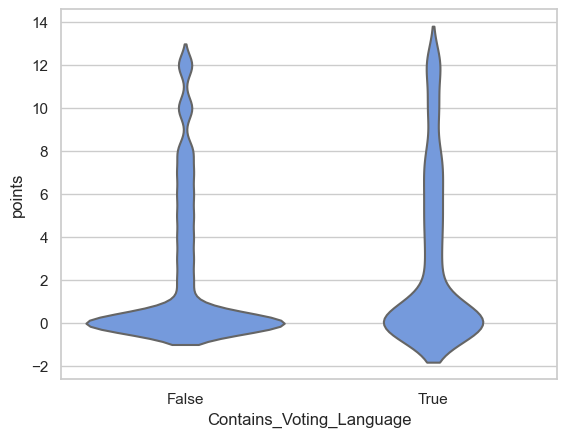

In [114]:
# violin plot
sns.violinplot(x='Contains_Voting_Language', y='points', data=df, inner=None, color="cornflowerblue")

# Gender Data

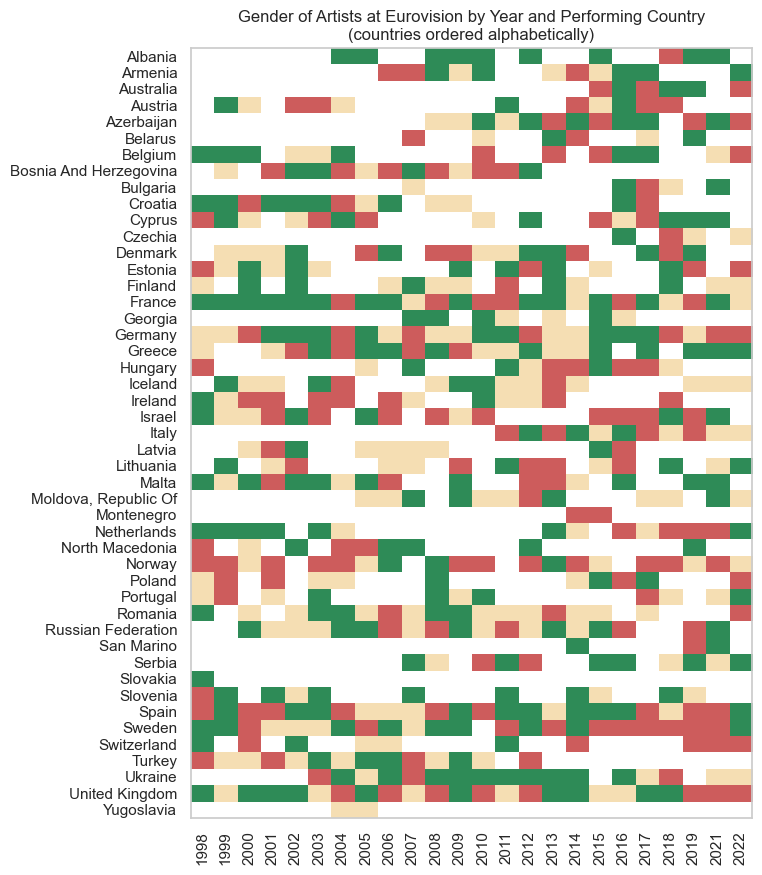

In [115]:
from matplotlib.colors import to_rgba

gender_df = df[['year', 'to_country', 'gender']].copy().drop_duplicates()

countries = gender_df.sort_values(by=['to_country'])['to_country'].drop_duplicates().to_list()
years = gender_df['year'].drop_duplicates().to_list()

gender_colours = {
    'female': to_rgba('seagreen'),
    'group': to_rgba('wheat'),
    'male': to_rgba('indianred'),
    'none': to_rgba('white')
}

gender = []
for year in years:
    missing = pd.DataFrame({'year': [year] * len(countries), 'to_country': countries, 'gender': ['none'] * len(countries)}).set_index('to_country')
    missing.update(gender_df[gender_df['year'] == year].set_index('to_country'))
    gender.append(list(map(lambda x: gender_colours[x], missing.sort_values(by=['to_country'])['gender'].to_list())))

gender = list(map(list, zip(*gender)))
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 10)
img = plt.imshow(gender, aspect=0.7)
ax.set_xticks(range(len(years)))
ax.set_xticklabels(years)
plt.xticks(rotation=90)
ax.set_yticks(range(len(countries)))
ax.set_yticklabels(list(map(str.title, countries)))
ax.grid(False)
plt.title('Gender of Artists at Eurovision by Year and Performing Country\n(countries ordered alphabetically)')
#plt.show()


plt.savefig('../../plots/performance_genders.pdf', bbox_inches='tight')

In [116]:
for gender in ['female', 'male', 'group']:
    count = len(gender_df[gender_df['gender'] == gender])
    print('Total {} performers: {} ({:.0%})'.format(gender, count, count/len(gender_df)))

def ratio(gender, x): return len([a for a in x if a == gender]) / len(x)

gender_df = gender_df.groupby('to_country').agg(
    female=pd.NamedAgg(column='gender', aggfunc=lambda x: ratio('female', x)),
    group=pd.NamedAgg(column='gender', aggfunc=lambda x: ratio('group', x)),
    male=pd.NamedAgg(column='gender', aggfunc=lambda x: ratio('male', x)),
)
gender_df = gender_df.sort_values(by=['female', 'group'], ascending=False)

gender_df.head()

Total female performers: 240 (40%)
Total male performers: 182 (30%)
Total group performers: 178 (30%)


,female,group,male
to_country,,,
slovakia,1.000000,0.000000,0.000000
albania,0.900000,0.000000,0.100000
san marino,0.666667,0.000000,0.333333
slovenia,0.636364,0.272727,0.090909
ukraine,0.588235,0.235294,0.176471


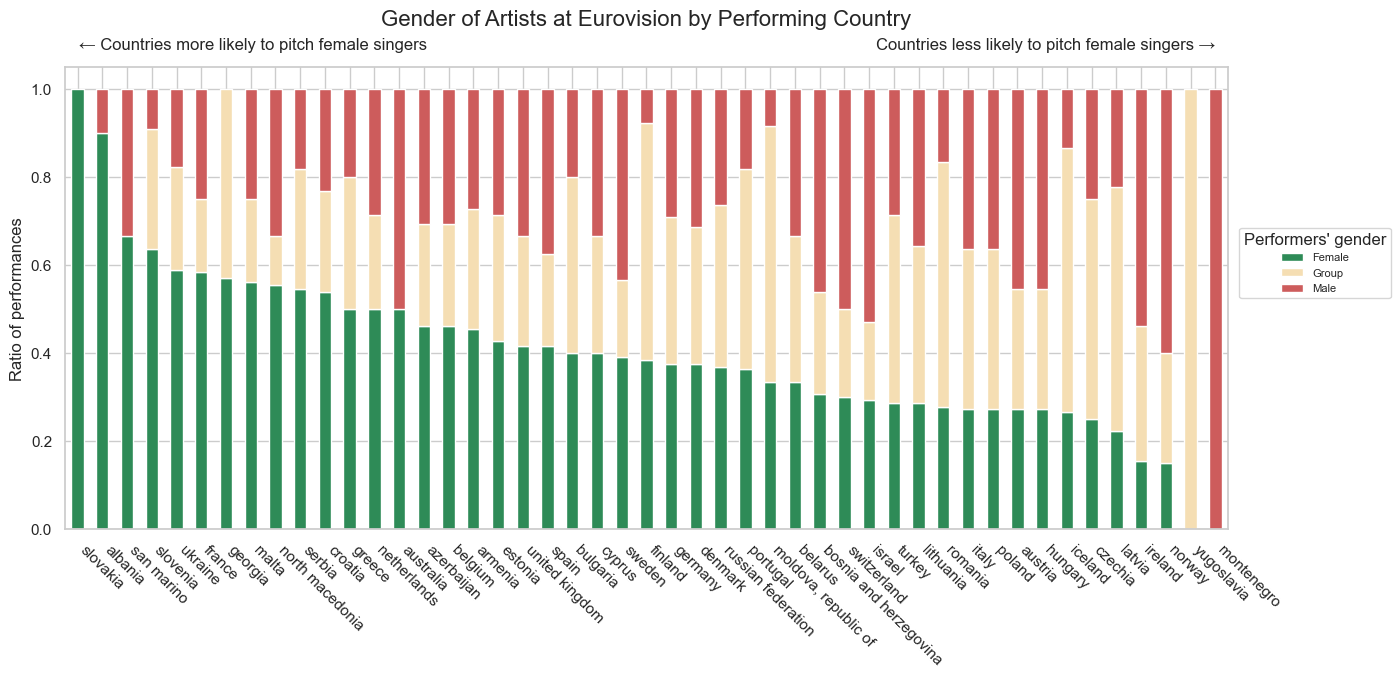

In [117]:
gender_colours = {
    'female': to_rgba('seagreen'),
    'group': to_rgba('wheat'),
    'male': to_rgba('indianred')#,
    #'none': to_rgba('white')
}

gender_df[gender_colours.keys()].plot(kind='bar', figsize=(15, 6), stacked=True, color=gender_colours)
plt.text(gender_df.shape[0] - 1, 1.1, 'Countries less likely to pitch female singers →', ha='right', va='center', fontsize=12)
plt.text(0.05, 1.1, '← Countries more likely to pitch female singers', ha='left', va='center',  fontsize=12)
plt.legend(['Female', 'Group', 'Male'], title="Performers' gender", loc=[1, 1], fontsize=8,  bbox_to_anchor=(0.51, 0., 0.5, 0.5))
plt.title('Gender of Artists at Eurovision by Performing Country', fontsize=16, pad=30)
plt.xticks(rotation=-45, ha='left')
plt.xlabel('')
plt.ylabel('Ratio of performances')
#plt.show()


plt.savefig('../../plots/gender_ratios.pdf', bbox_inches='tight')

In [118]:
gender_df = df[['year', 'to_code2', 'gender']].copy().drop_duplicates()

def ratio(gender, x): return len([a for a in x if a == gender]) / len(x)

gender_df = gender_df.groupby('year').agg(
    female=pd.NamedAgg(column='gender', aggfunc=lambda x: ratio('female', x)),
    group=pd.NamedAgg(column='gender', aggfunc=lambda x: ratio('group', x)),
    male=pd.NamedAgg(column='gender', aggfunc=lambda x: ratio('male', x)),
)

gender_df.head()

,female,group,male
year,,,
1998,0.480000,0.200000,0.320000
1999,0.478261,0.391304,0.130435
2000,0.333333,0.416667,0.250000
2001,0.260870,0.347826,0.391304
2002,0.583333,0.291667,0.125000


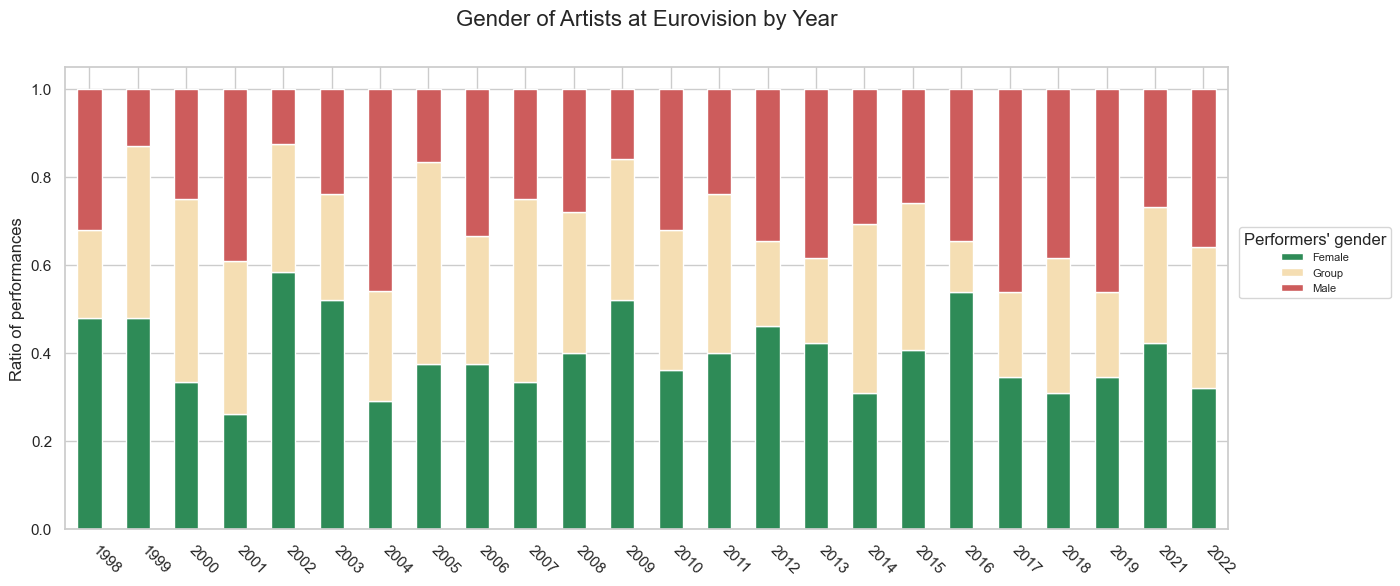

In [119]:
# subset gender_colours to genders in gender_df columns
# gender_colours = gender_colours[gender_df.columns.to_list()]

gender_df.plot(kind='bar', figsize=(15, 6), stacked=True, color=gender_colours)

plt.legend(['Female', 'Group', 'Male'], title="Performers' gender", loc=[1, 1], fontsize=8,  bbox_to_anchor=(0.51, 0., 0.5, 0.5))
plt.title('Gender of Artists at Eurovision by Year', fontsize=16, pad=30)
plt.xticks(rotation=-45, ha='left')
plt.xlabel('')
plt.ylabel('Ratio of performances')
#plt.show()

plt.savefig('../../plots/gender_by_year.pdf', bbox_inches='tight')

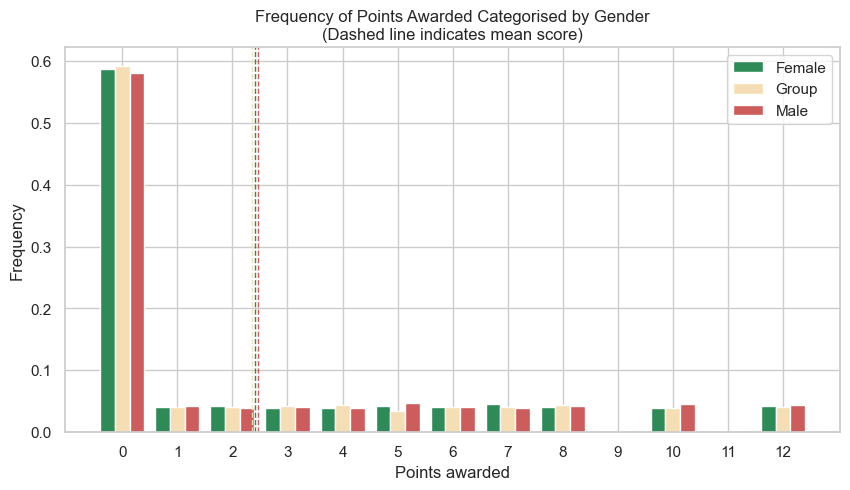

In [120]:
gender_df = df[['year', 'to_code2', 'gender', 'points']].copy()
genders = list(gender_colours.keys())[:3]
votes = []
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
for gender in genders:
    votes_df = gender_df[gender_df['gender'] == gender]['points']
    votes.append(votes_df)
    plt.axvline(votes_df.mean(), color=gender_colours[gender], linestyle='dashed', linewidth=1)

plt.hist(votes, density=True, bins=range(14), color=list(gender_colours.values())[:3], label=[gender.title() for gender in genders], align='left')
plt.xlabel('Points awarded')
plt.ylabel('Frequency')
plt.title('Frequency of Points Awarded Categorised by Gender\n(Dashed line indicates mean score)')
plt.legend()
plt.xticks(range(13))
ax.set_xticklabels([str(i) for i in range(13)])
#plt.show()

plt.savefig('../../plots/gender_points.pdf', bbox_inches='tight')

In [121]:
# TODO: check if male get higher average votes. 

# Collective Visualisations

- Heatmap for correlation plot
- Martin's plot
- Geographical plots
- Scatter plots

In [122]:
df_performance = df[['year', 'Artist', 'to_country', 
       'total_points', 'rank', 'to_code2', 
       'Official_languages', 'Language_sung', 'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'prop_emigrants_v2p', 'prop_emigrants_p2v', 'has_border',
       'comps_without_win',
       'Number_of_Languages', 'Contains_Own_Language', 'gender']].drop_duplicates()

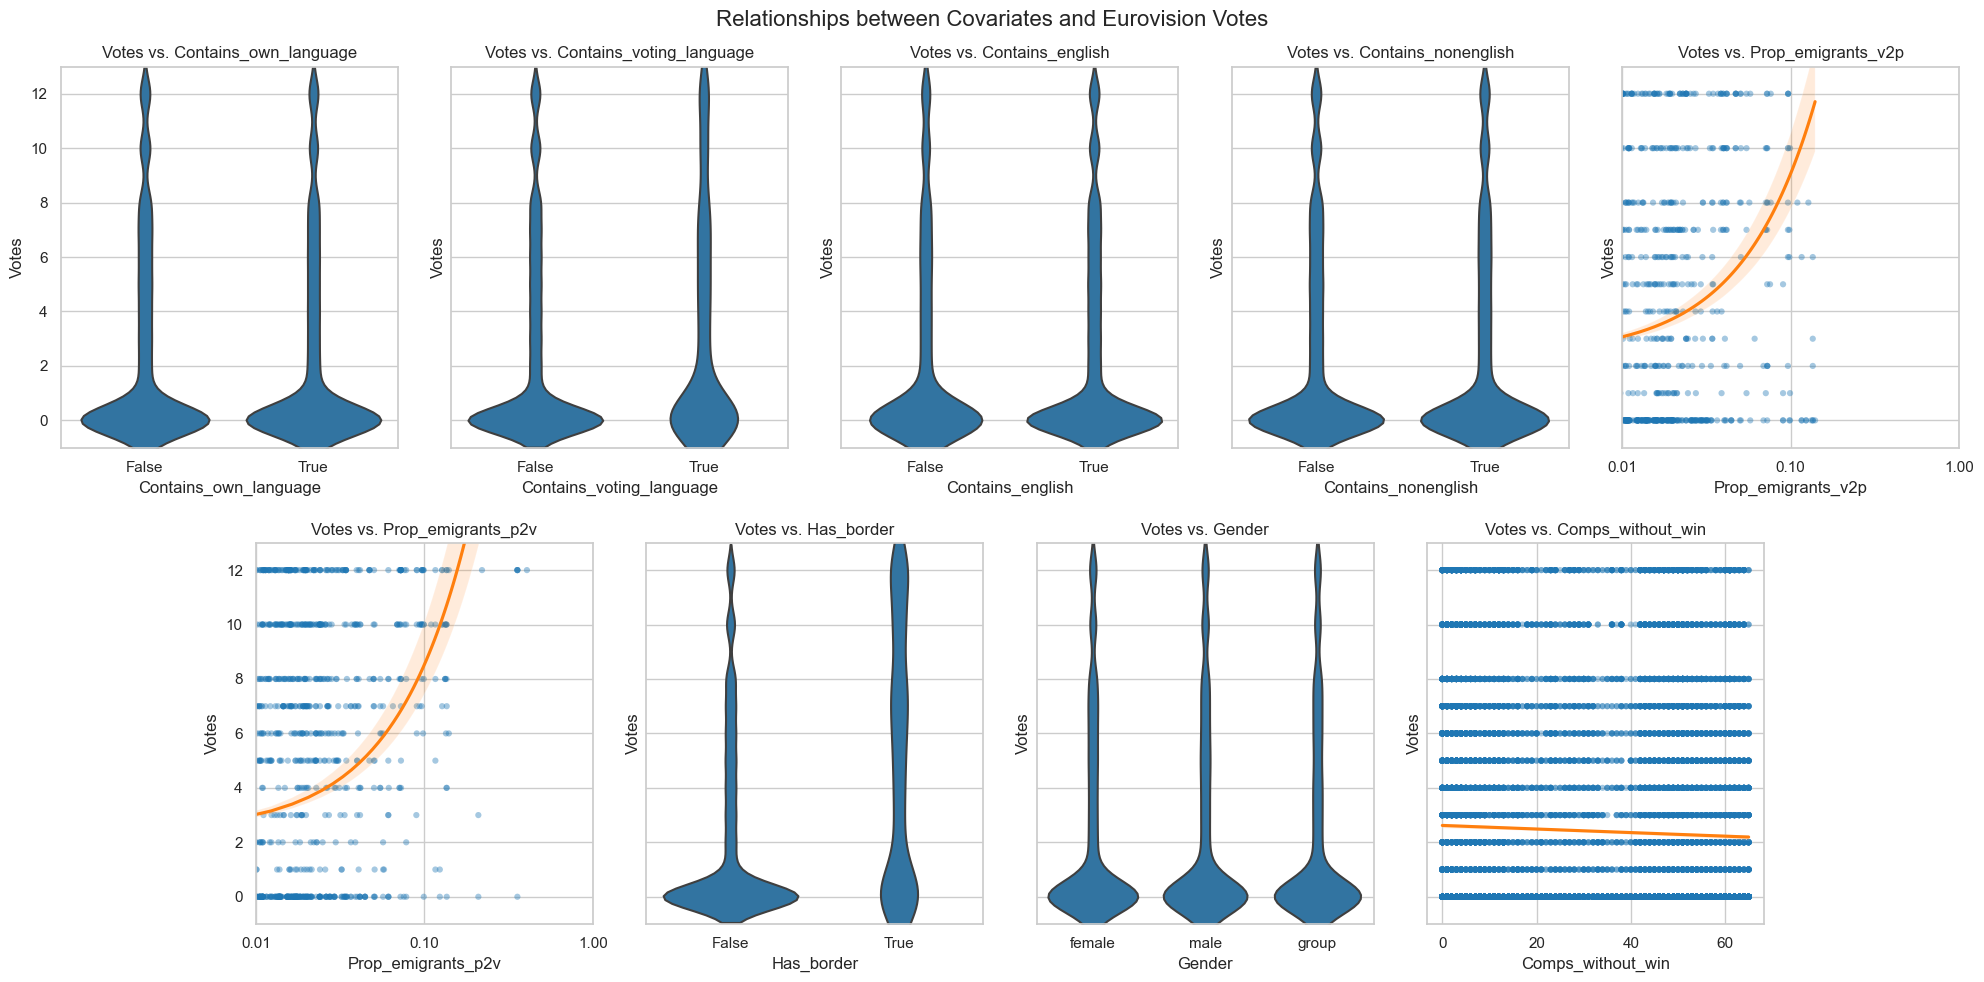

In [123]:
import matplotlib

# Define the variables of interest and their data types
vars_of_interest = {
    'Contains_Own_Language': 'binary',
    'Contains_Voting_Language': 'binary',
    'Contains_English': 'binary',
    'Contains_NonEnglish': 'binary',
    'prop_emigrants_v2p': 'numeric', 
    'prop_emigrants_p2v': 'numeric', 
    'has_border': 'binary',
    'gender': 'categorical', 
    'comps_without_win': 'numeric'
}

# Define the figure and axes
nc = int(np.ceil(len(vars_of_interest)/2))
fig, axes = plt.subplots(nrows=2, ncols=nc, figsize=(20, 10), sharey=True)

# Loop through the dictionary
for i, (key, value) in enumerate(vars_of_interest.items()):
    j, k = 0, i
    if i > (nc - 1):
        j, k = 1, i - nc

    if value == 'categorical':
        sns.violinplot(ax=axes[j, k], x=key, y='points', data=df, color='tab:blue', inner=None, showmeans=True)
    elif value == 'binary':
        sns.violinplot(ax=axes[j, k], x=key, y='points', data=df, color='tab:blue', inner=None, showmeans=True)
    else:
        sns.regplot(ax=axes[j, k], x=key, y='points', data=df, ci=95, 
                    color='tab:blue', scatter_kws={'alpha': 0.4, 'edgecolor': 'none', 's': 20}, 
                    line_kws={'color': 'tab:orange'})

        # if key contains Prop then log scale x axis
        if key.startswith('prop'):
            axes[j, k].set_xscale('log')
            axes[j, k].set_xticks([0.01, 0.1, 1, 10, 100])
            axes[j, k].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
            axes[j, k].set_xlim(0.01, 1)

    axes[j, k].set_ylim(-1, 13)
    axes[j, k].set_xlabel(key.capitalize())
    axes[j, k].set_ylabel('Votes')
    axes[j, k].set_title(f'Votes vs. {key.capitalize()}')

fig.suptitle('Relationships between Covariates and Eurovision Votes', fontsize=16)

fig.tight_layout()
fig.subplots_adjust(hspace=0.25)

# Shuffle the bottom row along there are an odd number of variables
if len(vars_of_interest) % 2 == 1:
    axes[1][-1].remove()
    # distance between two axes
    if len(vars_of_interest) >= 3:
        dist = axes[0][1].get_position().x0 - axes[0][0].get_position().x0
        for ax in axes[1]:
            pos = ax.get_position()
            ax.set_position([pos.x0 + (dist / 2), pos.y0, pos.width, pos.height])

#plt.show()

plt.savefig('../../plots/covars_vs_votes.pdf', bbox_inches='tight')

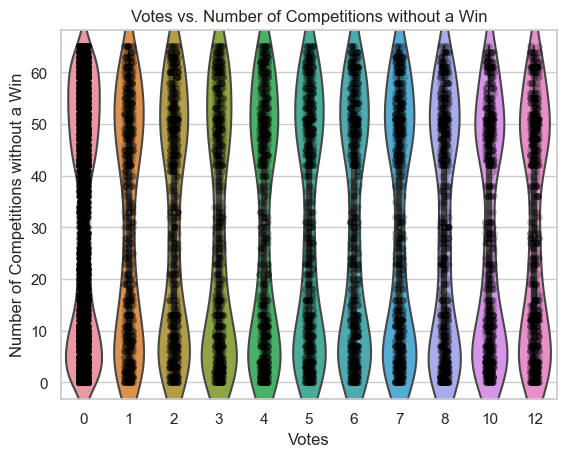

In [124]:
# plot comps_without_win vs. points
sns.violinplot(x='points', y='comps_without_win', data=df)
# add jitter
sns.stripplot(x='points', y='comps_without_win', data=df, jitter=True, color='black', alpha=0.2)

plt.title('Votes vs. Number of Competitions without a Win')
plt.ylabel('Number of Competitions without a Win')
plt.xlabel('Votes')
plt.show()


In [125]:
df[['points', 'comps_without_win']].corr()

,points,comps_without_win
points,1.000000,-0.040708
comps_without_win,-0.040708,1.000000


/var/folders/zq/08vbt_c13vn2qq5gr_x95vgw0000gr/T/ipykernel_11935/1498174252.py:8: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



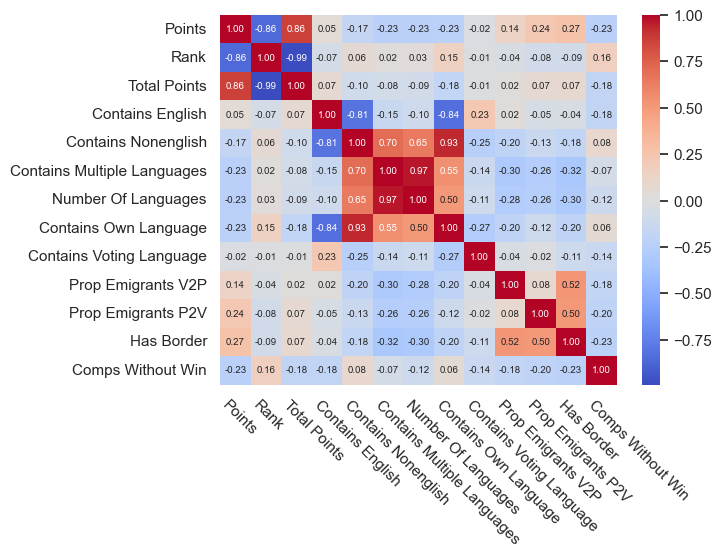

In [126]:
# correlation plot of numeric and binary variables
df_corr = df[['points', 'rank',
       'total_points', 'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'Number_of_Languages', 'Contains_Own_Language', 'Contains_Voting_Language',
       'gender',
       'prop_emigrants_v2p',  'prop_emigrants_p2v', 'has_border',
       'comps_without_win']].corr()

# heatmap of the correlation matrix
sns.heatmap(df_corr.corr(), cmap='coolwarm', annot=True, fmt='.2f', annot_kws={'fontsize': 7})

# replace _ in labels with space
labels = [label.replace('_', ' ').title() for label in df_corr.columns]
plt.xticks(np.arange(len(labels)), labels, rotation=-45, ha='left', va='top')
plt.yticks(np.arange(len(labels)) + 0.5, labels, rotation=0, va='center')


#plt.show()

plt.savefig('../../plots/covar_correlation_plot.pdf', bbox_inches='tight')



# Modelling

[...]

# Conclusions

Round everything up, draw conclusions.